In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import random
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
from sklearn.preprocessing import FunctionTransformer

import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from datetime import datetime, time
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

#model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

<style>
body {
    font-family: Georgia, serif;
}
</style>


In [2]:
social = pd.read_excel('social_data.xlsx', parse_dates=True)
social.head()

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video


In [3]:
#extract date and time variables 
social['Published Date']= social['Published Date'].dt.round('H')

#standardize columns to lower and replace blankspace
social.columns= [c.lower().replace(' ','_')for c in social.columns]

<span style='font-family:Serif'>

#### **O.DATA QUALITY ASSESSMENT**

Examining the percentage of missing values for impressions across various channels and campaigns is essential for analyzing campaign performance and ensuring data quality. Understanding the extent of missing values provides insights into potential data collection issues, tracking problems, or technical errors that may affect the accuracy and reliability of the analysis. 
***

**1. Account-Level Analysis:**

- CSGO: Notably, Link and Text campaigns on TWITTER have higher missing rates, indicating potential data collection issues specific to these campaigns.

- Content Creators: YOUTUBE campaigns by Content Creators have a 100% missing rate for both Link and Text media types, suggesting a complete absence of data for these specific campaigns. This highlights the need to investigate and rectify the data collection or tracking mechanisms for these campaigns.

- GENERAL: Album and Text campaigns on FBPAGE and INSTAGRAM have relatively higher missing rates, indicating areas for improvement in data collection processes.

- VALORANT: The Valorant account shows complete missing data for Link and Text campaigns, identifying and addressing the issues causing missing data in Link and Text campaigns can help improve data quality and ensure more comprehensive analyses.

**2. Account Type Analysis:**

- FACEBOOK & TWITTER: Link campaigns across these two account types tend to have much higher average missing rates compared to other media types. This highlights the need for closer examination of data collection processes and tracking mechanisms for Link campaigns on these platforms.

- YOUTUBE: Both Content Creators and Valorant campaigns on YOUTUBE have 100% missing rates for Link and Text media types. This complete lack of data indicates potential issues with data collection or tracking mechanisms specific to these sources. Addressing these issues is crucial for ensuring reliable and comprehensive data for future analyses.

**3. Media Type Analysis:**

- Album and Link campaigns have particularly high missing rates, indicating potential challenges in collecting or tracking data for these media types. 

- Text campaigns exhibit a high averaged missing rate across accounts, indicating potential difficulties in collecting or tracking data for campaigns relying on text-based content.


In [4]:
#Percentage of missing values for each
percentM= pd.DataFrame(social[(social['total_impressions']==0)&(social['total_engagements']==0)].groupby(
    ['account','account_type','media_type']).size().reset_index(name='missingVal'))

fullPercent= social.groupby(['account','account_type','media_type']).size().reset_index(name='totalVal').merge(
    percentM, how='inner', on=['account','account_type','media_type'])
fullPercent['missingRate']= fullPercent.apply(lambda row:row.missingVal/row.totalVal, axis=1 )

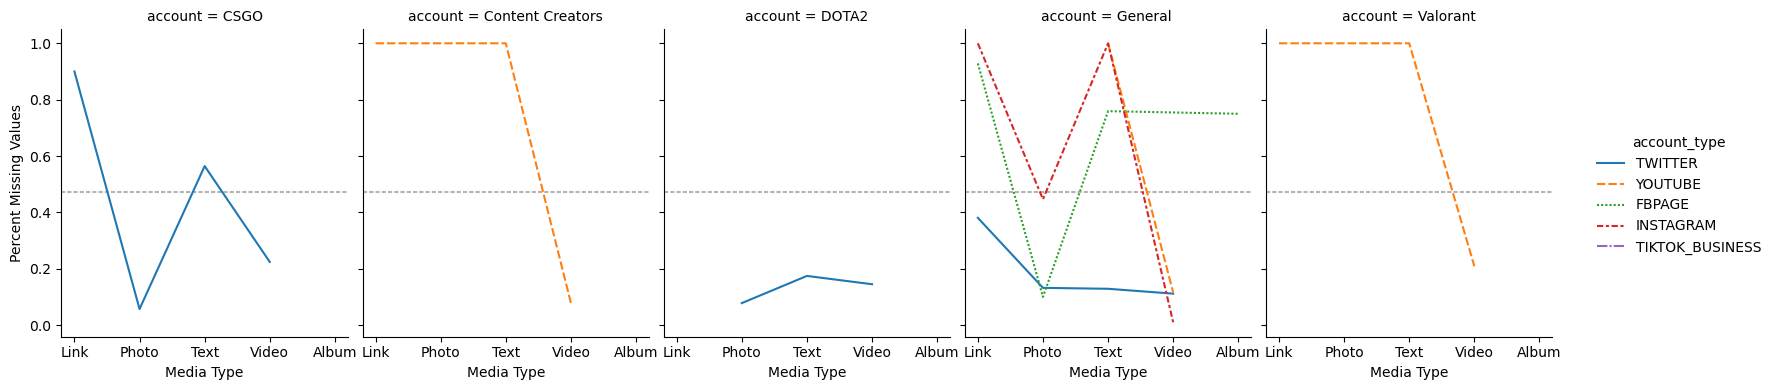

In [5]:
missingCat = sns.relplot(data=fullPercent, x='media_type',y='missingRate', hue='account_type',style='account_type', col='account',
                         height=4, aspect=.8, kind='line')

missingCat.map(plt.axhline, y=fullPercent.loc[:,'missingRate'].mean(), color=".7", dashes=(2, 1), zorder=0).set_axis_labels("Media Type", "Percent Missing Values").tight_layout(w_pad=0)

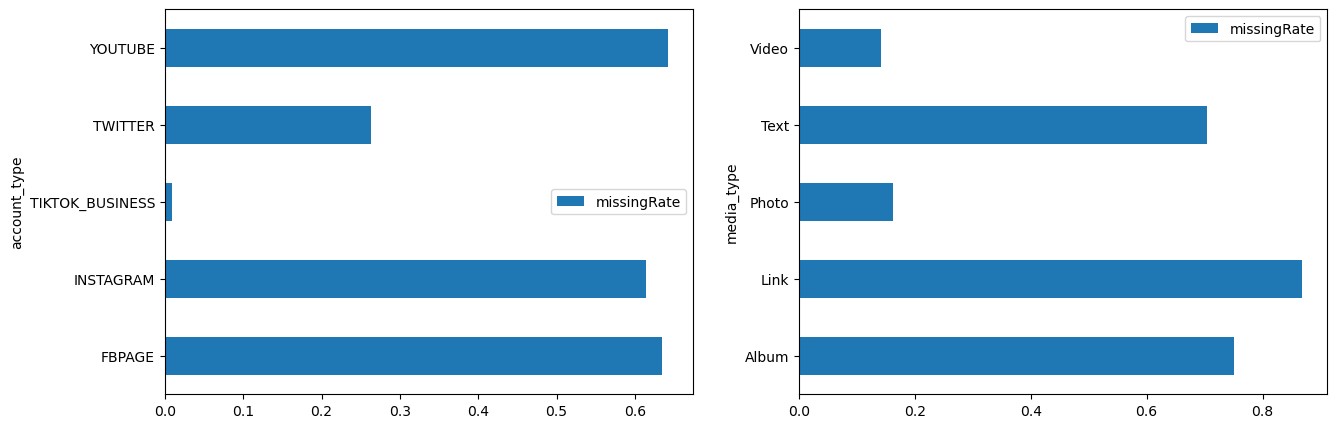

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
pd.pivot_table(fullPercent,index=['account_type'],aggfunc={'missingRate':'mean'}).plot.barh(ax=ax1)
pd.pivot_table(fullPercent,index=['media_type'],aggfunc={'missingRate':'mean'}).plot.barh(ax=ax2)
plt.show()

<span style='font-family:Georgia'>

#### **I. LIKELIHOOD OF ACHIEVING 15% ENGAGEMENT RATE**

Based on the analysis of the average engagement rates across campaigns, it is important to note that the likelihood of achieving a 15% engagement rate depends on various factors, including the specific campaign, platform, content type, target audience, and overall campaign strategy. However, based on the average engagement rates observed in the analysis, which range from approximately 3% to 6.8%, the likelihood of achieving a 15% engagement rate is 8.88%. It would require implementing highly effective and targeted strategies that resonate deeply with the audience, along with exceptional content quality, compelling messaging, and optimized campaign execution.
***

In [7]:
social['engag_rate']= social.apply(lambda row:row.total_engagements/row.total_impressions
                                   if row.total_engagements !=0 else np.inf, axis=1 )

for col in ['account','account_type','campaign_name','media_type']:
    social[col]= social[col].astype('category')
    print(social[col].unique())
    social[col]=social[col].apply(lambda x: x.strip())

social= social[(social['total_impressions']!=0)&(social['total_engagements']!=0)].reset_index(drop=True)
#insepect error 
print(social[social['engag_rate']>1.0])
social= social[social['engag_rate']<=1].drop(['total_impressions','total_engagements'],axis=1)
socialT= social.set_index('published_date')

['CSGO', 'General ', 'DOTA2', 'Content Creators', 'Valorant', 'General']
Categories (6, object): ['CSGO', 'Content Creators', 'DOTA2', 'General', 'General ', 'Valorant']
['TWITTER', 'FBPAGE', 'INSTAGRAM', 'TIKTOK_BUSINESS', 'YOUTUBE', 'LINKEDIN_COMPANY']
Categories (6, object): ['FBPAGE', 'INSTAGRAM', 'LINKEDIN_COMPANY', 'TIKTOK_BUSINESS', 'TWITTER', 'YOUTUBE']
['N/A ', 'Community Engagement ', 'Evergreen ', 'Evil Exhibited ']
Categories (4, object): ['Community Engagement ', 'Evergreen ', 'Evil Exhibited ', 'N/A ']
['Text', 'Video', 'Photo', 'Link', 'Carousel', 'Mixed', 'Album']
Categories (7, object): ['Album', 'Carousel', 'Link', 'Mixed', 'Photo', 'Text', 'Video']
          published_date  account account_type campaign_name  \
611  2023-03-10 13:00:00  General       FBPAGE           N/A   
2348 2023-01-19 06:00:00  General       FBPAGE           N/A   
2503 2023-01-05 12:00:00  General       FBPAGE           N/A   

      total_impressions  total_engagements media_type  engag_rate  

In [8]:
##check percentage of campaigns achieves more than 15%
engage15= socialT[socialT['engag_rate']>.15]
print(round(len(engage15)/len(social),4)) ##8.88%

0.0888


<span style='font-family:Serif'>

#### **II. COMPARATIVE ANALYSIS OF MEIDA TYPE AND ACCOUNT**

Analyzing the performance of different media types across accounts helps identify strengths and weaknesses in engagement rates. This information can guide strategic decisions, such as focusing on platforms that yield higher engagement, improving data collection processes, and diversifying the brand's presence across multiple channels to reach a wider audience.
***
**1. Account-Level Analysis:**

- CSGO: CSGO's Video campaigns on TWITTER tend to drive a higher engagement rate compared to the CONTENT CREATOR and VALORANT's performances on YOUTUBE, about the same as the DOTA2. This could be due to the dynamic video experience and higher shareability offered by TWITTER,compared to YOUTUBE, which resonates well with the target audience of CSGO.

- DOTA2: Photo and Text campaigns on TWITTER of DOTA2 significantly outperform those of CSGO, which indicates that DOTA2's target audience is more active on TWITTER and there are more campaigns published than CSGO, resulting in higher engagement rates. 

- CONTENT CREATOR & VALORANT: The Valorant account shows complete missing data for Link and Text campaigns, highlighting the need to address data collection issues to improve data quality and gain insights into engagement rates. Both accounts are exclusively available on YOUTUBE, which suggests they should consider increasing their brand presence on other platforms such as TWITTER and TIKTOK to expand their reach and potentially enhance engagement rates.

- GENERAL: FBPAGE demonstrates the highest engagement rate for Photo, Text, and Video campaigns compared to other channels. Video campaigns on FBPAGE perform exceptionally well, while TIKTOK and TWITTER outperform YOUTUBE and INSTAGRAM in terms of engagement rate. However, LINKEDIN, across all media types, falls below the average engagement rate observed across all accounts, indicating potential challenges in connecting with the target audience on that platform.


**2. Campaign-level Analysis**

The Community Engagement campaign demonstrates a relatively higher average engagement rate. To further enhance its success, consider allocating more album,mixed and video campaign and efforts to this campaign. On the other hand, the Evil Exhibited campaign shows a relatively lower average engagement rate. To enhance its effectiveness, it is advisable to analyze the underlying factors contributing to the lower engagement. Evaluate the campaign's messaging, content quality, and targeting strategies to ensure they align with the preferences and interests of the intended audience. Consider conducting audience research to gain insights into their preferences and develop content that captures their attention and sparks engagement. Evergreen Campaign is currently limited to Video ads, consider to launch mixed and album type content on relevant channels. 

#### **III.Overarching Media Strategy**
***
1. FBPAGE Account:
   > Continue leveraging the high average engagement rates for album, photo, text, and video campaigns on FBPAGE. Explore a mix of content formats to cater to different user preferences. Engage with the community through interactive posts, contests, or live events to foster stronger connections.


2. Instagram Account:
   >Although Instagram has lower average engagement rates compared to other platforms, focus on carousel and photo campaigns, which show relatively higher engagement rates. Use high-quality visuals, compelling captions, and relevant hashtags to increase discoverability and encourage engagement.


3. LinkedIn Account:
   > Given the lower average engagement rates on LinkedIn, prioritize link and photo campaigns to convey valuable industry insights and thought leadership. Engage with the professional community by sharing informative articles, infographics, or industry trends.


4. TikTok Business Account:
   > Capitalize on the high average engagement rate for video campaigns on TikTok. Create short, entertaining, and shareable content that aligns with TikTok's dynamic and creative nature. Engage with trending challenges or collaborate with popular TikTok creators to increase visibility and engagement.


5. Twitter Account:
   > Focus on link, mixed, and photo campaigns on Twitter, as they have higher average engagement rates. Use concise and compelling copy, appealing visuals, and relevant hashtags to maximize reach and engagement. Engage with the Twitter community through replies, retweets, and active participation in relevant conversations. Experiment with different types of content and storytelling techniques to evoke more emotion and connection with the CSGO and DOTA2 community.


6. YouTube Account:
   > Continue prioritizing video campaigns on YouTube for Valorant. Explore a mix of gameplay highlights, tutorials, and entertaining content to engage the Valorant community. Collaborate with popular Valorant content creators or streamers to expand reach and engagement. Explore collaborations with other content creators or influencers to expand reach and engagement. Additionally, consider incorporating interactive elements such as polls or challenges to encourage viewer participation.


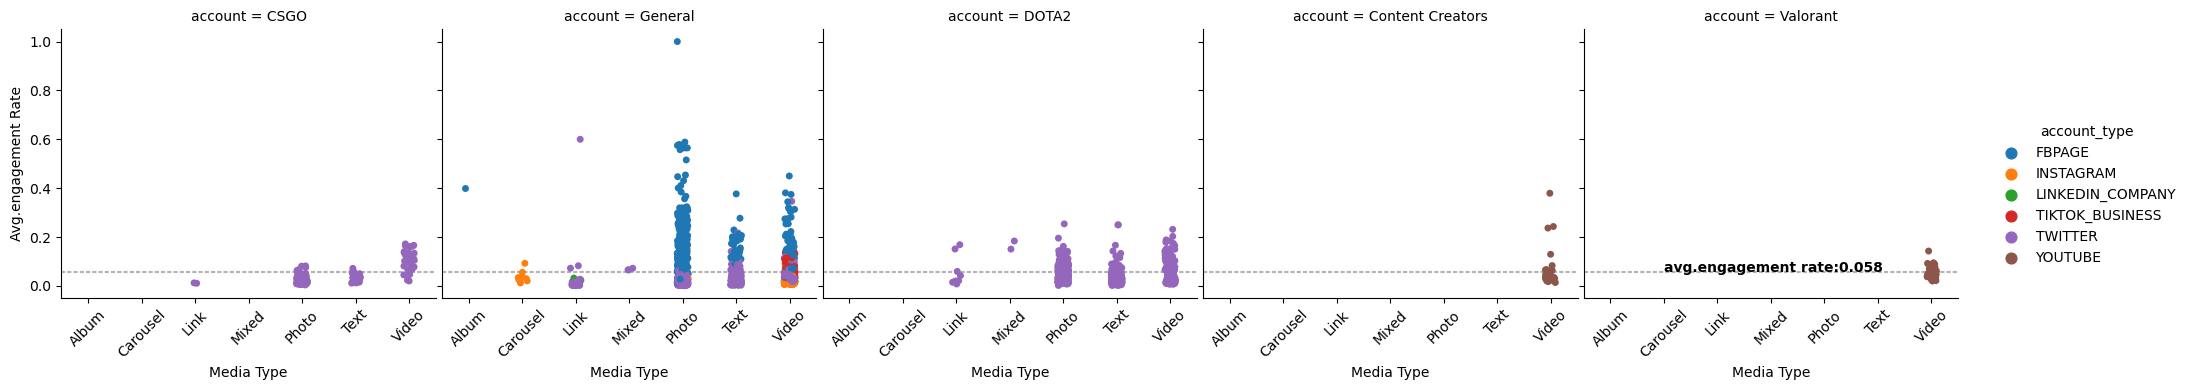

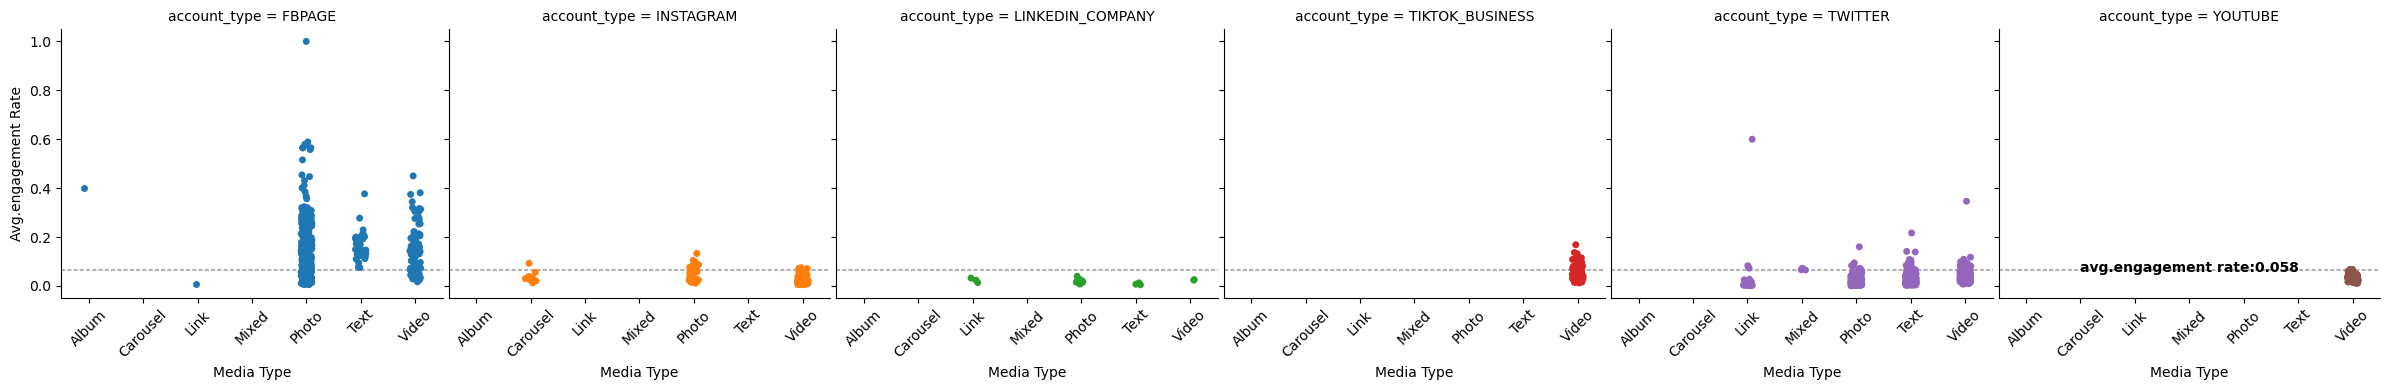

In [9]:
fullE= sns.catplot(y='engag_rate',x='media_type',data=social,
            hue='account_type', col='account', height=4, kind='strip')
fullE.set_xticklabels(rotation=45)
fullE.map(plt.axhline, y=social.loc[:,'engag_rate'].mean(), 
          color=".7", dashes=(2, 1), zorder=0).set_axis_labels("Media Type", "Avg.engagement Rate").tight_layout(w_pad=0.1)
plt.text(1,0.058,'avg.engagement rate:0.058',horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()
generalE= sns.catplot(y='engag_rate',x='media_type',data=social[social['account']=='General'],
            hue='account_type', col='account_type', height=4, kind='strip')
generalE.set_xticklabels(rotation=45)
generalE.map(plt.axhline, y=social[social['account']=='General'].loc[:,'engag_rate'].mean(), 
             color=".7", dashes=(2, 1), zorder=0).set_axis_labels("Media Type", "Avg.engagement Rate").tight_layout(w_pad=0.1)
plt.text(1,0.058,'avg.engagement rate:0.058',horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

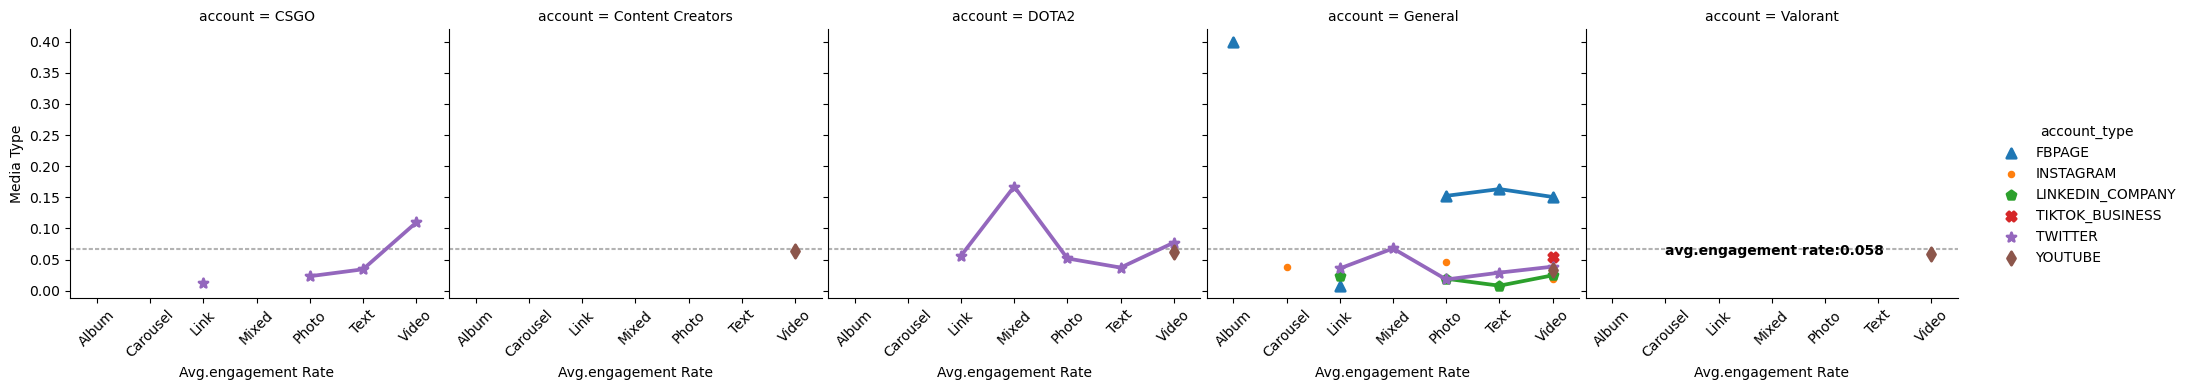

In [10]:
engageC= social.groupby(['account','account_type','media_type'])['engag_rate'].agg(['mean']).stack().reset_index().rename(columns={'level_3':'range',0:'meanVals'})
engageP = sns.catplot(data=engageC,y='meanVals',  x='media_type',hue='account_type',style='account_type', col='account',  height=4, kind='point',
                      markers=["^", ".","p",'X','*','d','v'])
#engageP.set(ylim=(0,None)
engageP.set_xticklabels(rotation=45)
engageP.map(plt.axhline, y=engageC.loc[:,'meanVals'].mean(), color=".7", dashes=(2, 1), zorder=0).set_axis_labels( "Avg.engagement Rate","Media Type").tight_layout(w_pad=0.1)
plt.text(1,0.058,'avg.engagement rate:0.058',horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

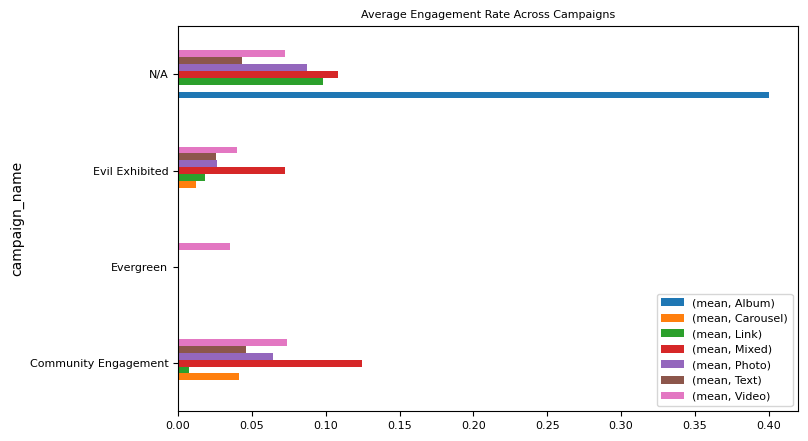

In [11]:

avg2=socialT.groupby(['campaign_name','media_type'])['engag_rate'].agg(['mean']).unstack()
avg2.dropna(how='all').plot.barh(figsize=(8,5),rot=0,fontsize=8)
plt.title('Average Engagement Rate Across Campaigns',fontsize=8)
plt.legend(fontsize=8)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


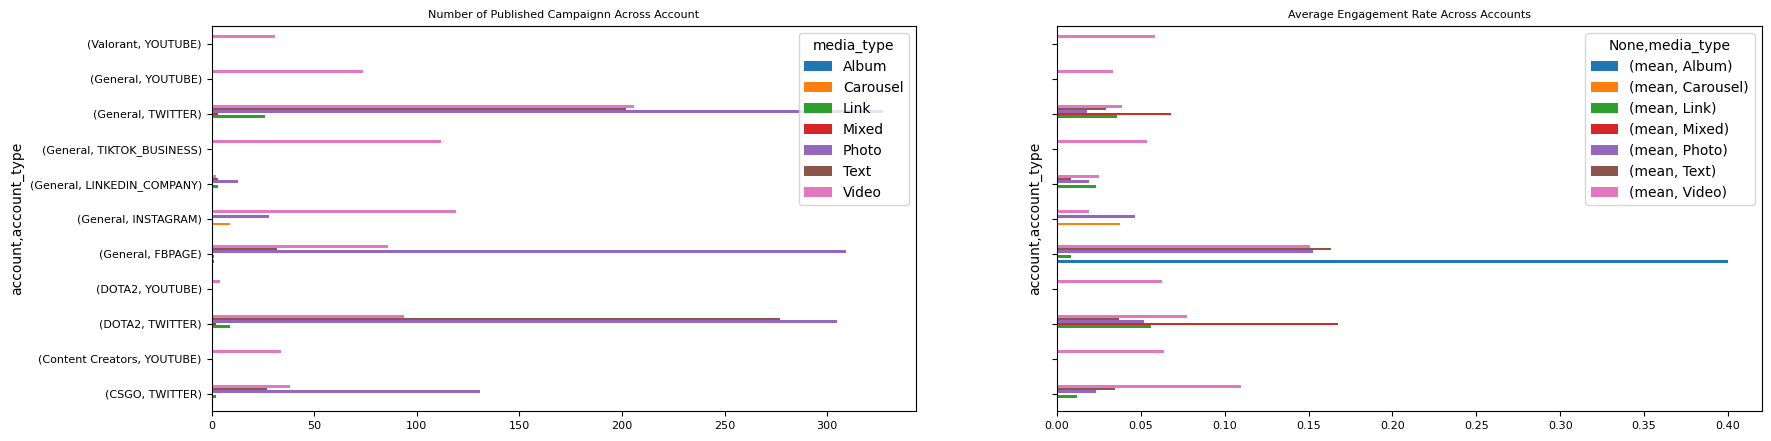

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

#campaign distribution 
distribution= socialT.groupby(['account','account_type','media_type'])['engag_rate'].count().unstack()
distribution=distribution.loc[~(distribution==0).all(axis=1)]
distribution.plot.barh(rot=0,fontsize=8,ax=ax1)
plt.legend(fontsize = 8)
ax1.set_title('Number of Published Campaignn Across Account',fontsize=8)

avg=socialT.groupby(['account','account_type','media_type'])['engag_rate'].agg(['mean']).unstack()
avg.dropna(how='all').plot.barh(rot=0,fontsize=8,ax=ax2)
ax2.yaxis.set_ticklabels([])
ax2.set_title('Average Engagement Rate Across Accounts', fontsize=8)
plt.show()

<span style='font-family:Serif'>

#### **IV. COMPARATIVE ANALYSIS OF DAY AND TIME OF PERFORMANCE IN ENGAGEMENT RATES**

This analysis examines the engagement rates of various campaigns across multiple accounts to gain insights into the effectiveness of different platforms and account types across time and day. The objective is to identify trends, strengths, and weaknesses in engagement rates to optimize campaign strategies and foster meaningful interactions with the community. By strategically scheduling campaign releases during peak engagement periods on FBPAGE and YouTube, higher participation and interaction can be achieved. Additionally, focusing on reevaluating campaign strategies and exploring tactics to boost engagement on Instagram and Linkedin will help improve its performance as a community engagement platform. By implementing the recommendations asfollows, future campaigns can effectively leverage peak engagement hours and enhance engagement rates across multiple platforms.

**Enhancing Community Engagement Strategies: Exploring Effective Platforms and Account Types**
>
> As the focus of community engagement campaign is on Twitter as a primary platform for DOTA2 & CSGO players, Youtube and TikTok should be considered to further enhance the performance. Community engagement campaigns on Twitter may benefit from exploring strategies that evoke more emotion and connection with the targeted audience. The DOTA2 Twitter account's consistent outperformance, compared to CSGO's, suggests a stronger engagement with fans. Additionally, leveraging the strengths of the FBPAGE, particularly during peak hours, can enhance interaction. Furthermore, the Content Creator YouTube account's exceptional engagement rate highlights the potential of YouTube for fostering meaningful interactions.
>

1. Account-Level Performance:
- CSGO & DOTA2 Twitter Accounts: DOTA2 consistently outperforms CSGO on Twitter, with an average engagement rate approximately 3% higher. This indicates a stronger connection between DOTA2 fans and community engagement campaigns on the platform. Notably, CSGO experiences a surge in engagement towards the end of March, suggesting potential opportunities for campaign optimization to better align with CSGO fans on Twitter.

- FBPAGE Account: The FBPAGE account demonstrates the highest engagement rate among all account types, surpassing other platforms significantly. This highlights the effectiveness of Facebook in driving community interaction, particularly for video, text, and photo campaigns. Leveraging the strengths of FBPAGE during peak hours can further enhance community engagement.

- LinkedIn Account: Across all time frames, LinkedIn consistently underperforms, indicating challenges in engaging the target audience for community engagement campaigns on this platform. Further exploration and adaptation of strategies may be required to improve LinkedIn campaign performance.

- Content Creator YouTube Account: The Content Creator YouTube account achieves the highest engagement rate across all channels, averaging over 20%. This underscores the potential of YouTube as a platform for fostering meaningful interactions with the community. Consider increasing the number of campaigns launched on YouTube to leverage its immersive and emotionally resonant nature.

2. Hourly Engagement Patterns:
- FBPAGE, Instagram, and TikTok exhibit the highest engagement rates among all account types. Notably, engagement peaks are observed around 5 am and 8 pm, indicating optimal hours for generating community interaction. Further analysis is needed to understand the underlying factors contributing to these patterns. For YouTube, a surge in engagement is observed during lunch hours, which may be attributed to users' preferences for video content during that time.

***

**Optimizing Evergreen Campaigns: Leveraging Platforms and Strategic Timing**
>
>To maximize the impact of evergreen campaigns, it is advisable to allocate more resources and content to TikTok, as it consistently outperforms YouTube and Instagram in terms of engagement rates. Exploring creative and captivating video formats on TikTok will help capture the attention and interest of the community. Increasing the number of campaigns launched on YouTube is also recommended, leveraging its immersive and emotionally resonant nature. Furthermore, reevaluating campaign strategies on Instagram and exploring new tactics such as interactive features, influencer collaborations, or user-generated content can help boost audience participation and interaction on this platform.
>

1. Account & Hourly-Level Performance: 
- TikTok and YouTube General Account: TikTok consistently outperforms YouTube in terms of engagement rates, indicating its effectiveness in capturing the attention and interest of the target audience. Consider allocating more resources and content to TikTok for maximum impact. 

- Instagram General Account: Instagram shows the lowest engagement rate among the three platforms. Further exploration and adaptation of strategies are recommended to improve campaign performance on this channel.

- FBPAGE and Twitter General Account: Notably, campaigns launched on 02/17 experienced significantly higher engagement rates on both FBPAGE and Twitter, despite the early morning publishing time. Leveraging these insights, it is advisable to schedule campaigns on these platforms during similar timeframes to maximize engagement. 

***

**Enhancing Evil Exhibit Campaigns: Channel Effectiveness and Optimal Timing**
>
>For Evil Exhibit campaigns, it is recommended to allocate more resources and focus on producing compelling and visually appealing video content on the YouTube account, which has shown a higher engagement rate compared to the Twitter account. Additionally, aligning campaign launches with weekends, when higher average engagement rates are observed, can be advantageous. Considering the leisure time preferences of the target audience and creating campaigns that cater to their entertainment and relaxation needs will help optimize engagement.
>

1. Account-Level Performance
- Twitter and YouTube: The VALORANT YouTube account outperforms the DOTA2 Twitter account, with approximately a 4% higher engagement rate. This highlights the effectiveness of YouTube for engaging VALORANT players. Additionally, campaigns published during weekends tend to yield higher average engagement rates, suggesting a preference for leisure time consumption. Consider aligning campaign launches with weekends to optimize engagement.

2. Hourly Engagement Patterns:
- FBPAGE and YouTube: Both FBPAGE and YouTube demonstrate higher engagement rates during afternoon hours, especially on Fridays and Sundays. To leverage this pattern, it is recommended to strategize campaign launches accordingly. Allocating resources and scheduling content releases during these peak engagement periods will likely yield higher interaction and participation from the community. This can include publishing compelling videos, organizing live events or discussions, or offering exclusive content during these targeted hours


- Instagram: Instagram consistently underperforms across all media channels. To improve campaign performance on this platform, it is necessary to reevaluate the current strategies and explore tactics that can enhance engagement. This can involve various approaches, such as incorporating interactive features, leveraging influencer partnerships, hosting contests or giveaways, or creating visually appealing and shareable content. By analyzing the preferences and behavior of the target audience on Instagram, tailored campaigns can be designed to capture their attention and encourage active participation. Experimenting with different content formats, storytelling techniques, or user-generated content can also help boost engagement and foster a sense of community on Instagram.

In [13]:
#Adding holiday attribute
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2023-01-01', end='2023-03-31')
social[['date','hour']]= social['published_date'].astype(str).str.split(expand=True)
social['date']= pd.to_datetime(social['date'],format='%Y-%m-%d')

social['holiday']=0
for id, row in social.iterrows():
    if row['date'] in holidays:
        social.loc[id,'holiday']=1
    else:
        social.loc[id,'holiday']=0

social['month']=pd.DatetimeIndex(social['published_date']).month
social['day']=pd.DatetimeIndex(social['published_date']).day
social['dayofweek']= pd.DatetimeIndex(social['published_date']).day_of_week
social['monthstart']=pd.DatetimeIndex(social['published_date']).is_month_start
social['hour']=pd.DatetimeIndex(social['published_date']).hour
#morning as 0, afternoon 1, night 2
social['timeofday']=social.hour.apply(lambda date:0 if 4<=date<=11 else 1 if 12<=date<=20 else 2)



social['weekend']=0
for id, row in social.iterrows():
    if row['dayofweek']==5 or row['dayofweek']==6 or row['dayofweek']==4:
        social.loc[id,'weekend']=1
    else:
        social.loc[id,'weekend']=0

In [14]:
from matplotlib.dates import date2num

In [15]:
def plotTimeSeries(df, dateTime, group, value_name, figsize=(15,5), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.
    '''
            
    xtick_locator = mdates.DayLocator(interval=5)
    xtick_dateformatter = mdates.DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([group]):
        ax = grp.plot(ax=ax, kind='line', x=dateTime, y=value_name, label=key, marker='.')
        for i in range(len(grp.weekend)-1):
            if grp.weekend.values[i]==1:
                ax.axvspan(date2num(grp.date.values[i]), date2num(grp.date.values[i+1]), color="crimson", alpha=0.3)
                
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=45, )
    _ = plt.grid()
    _ = plt.xlabel('',fontsize=8)
    _ = plt.axhline(y=df.loc[:,'engag_rate'].mean(), color="black", lw=2, zorder=0, label='account level- avg.engagement_rate')
    _ = plt.legend(fontsize= 8)
    #_ = plt.ylim(0, df[value_name].max() * 1.1)
    _ = plt.ylabel(value_name,fontsize=8)
    _ = plt.tick_params(axis='both',labelsize=7)
    if title is not None:
        _ = plt.title(title,fontsize=10)
    _ = plt.show()

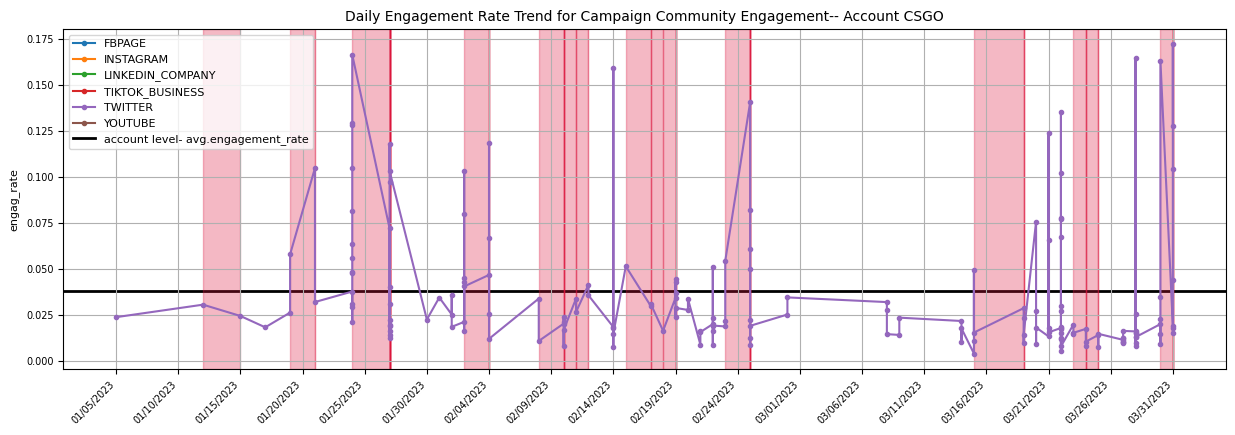

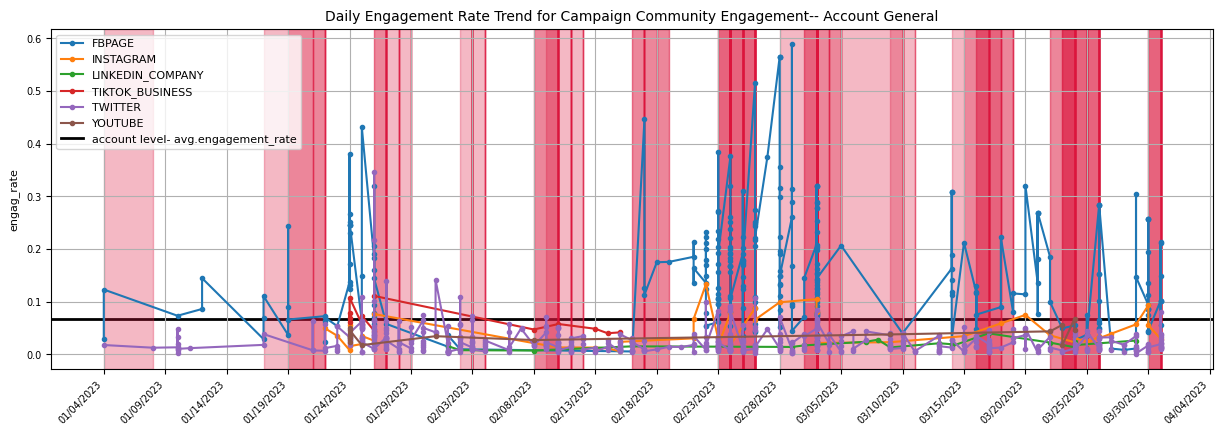

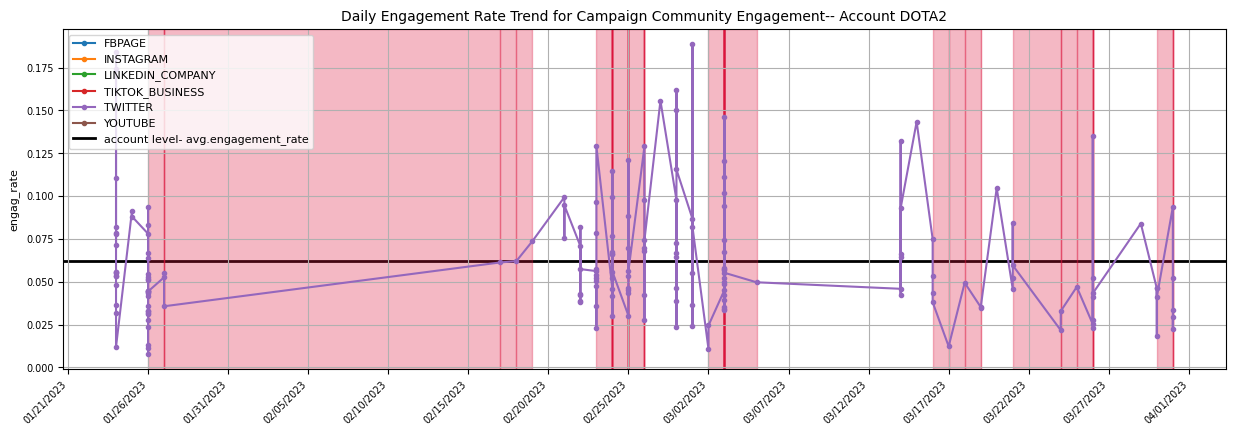

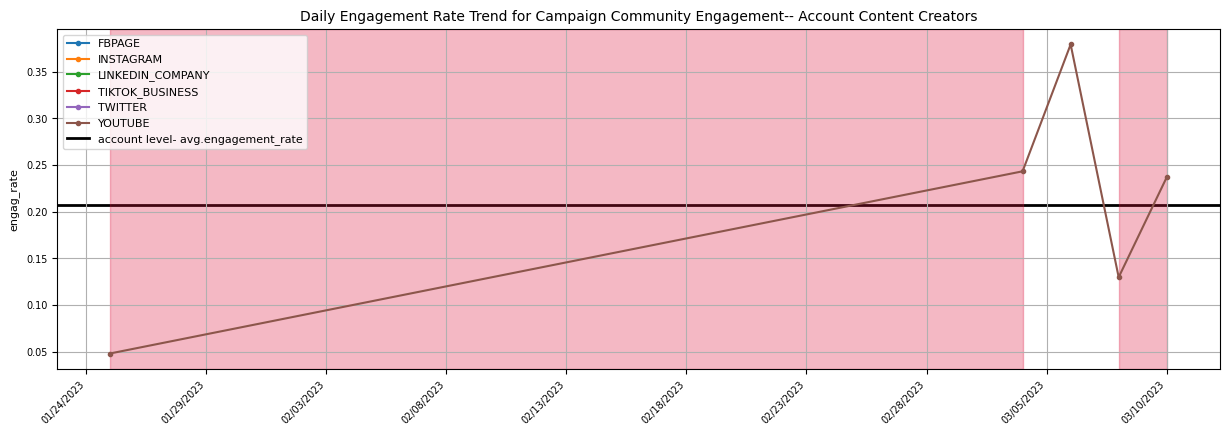

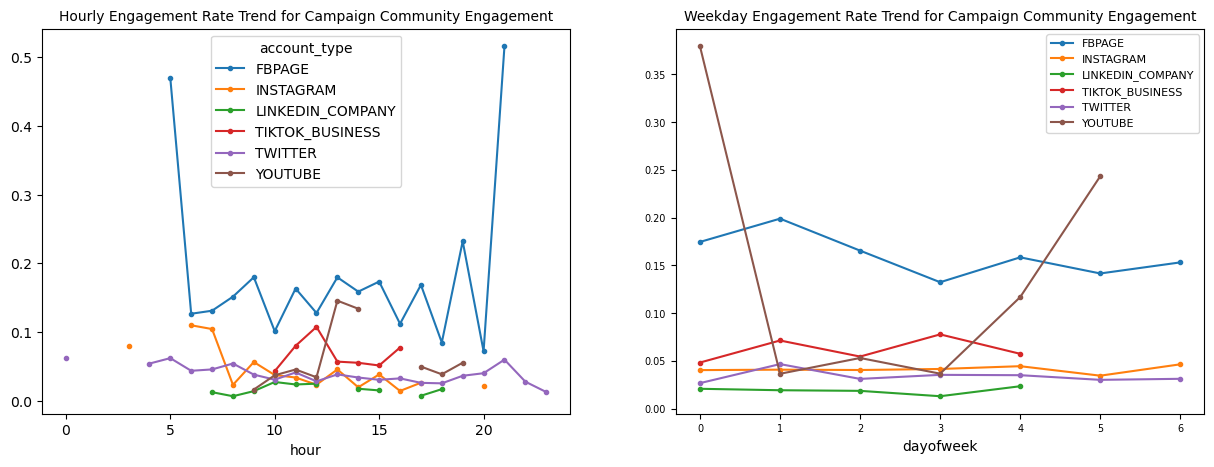

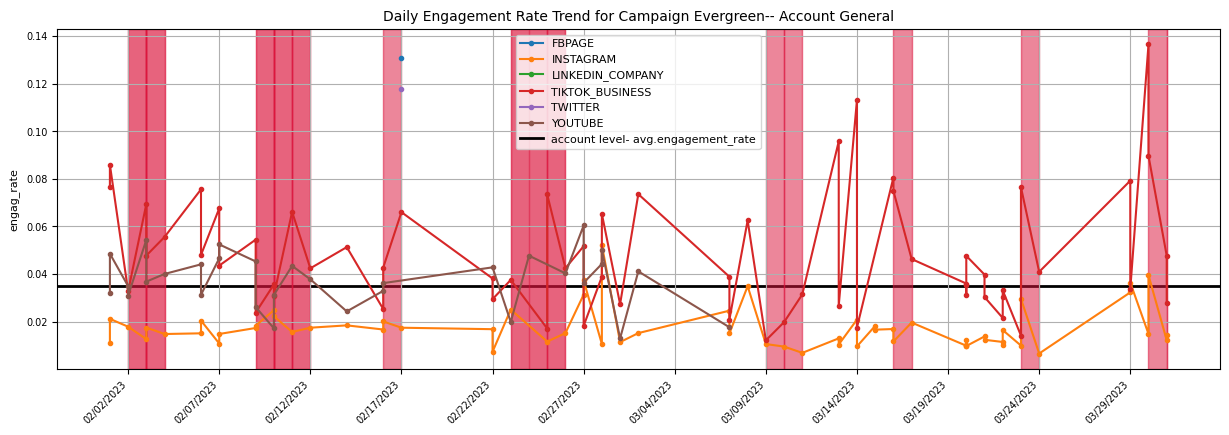

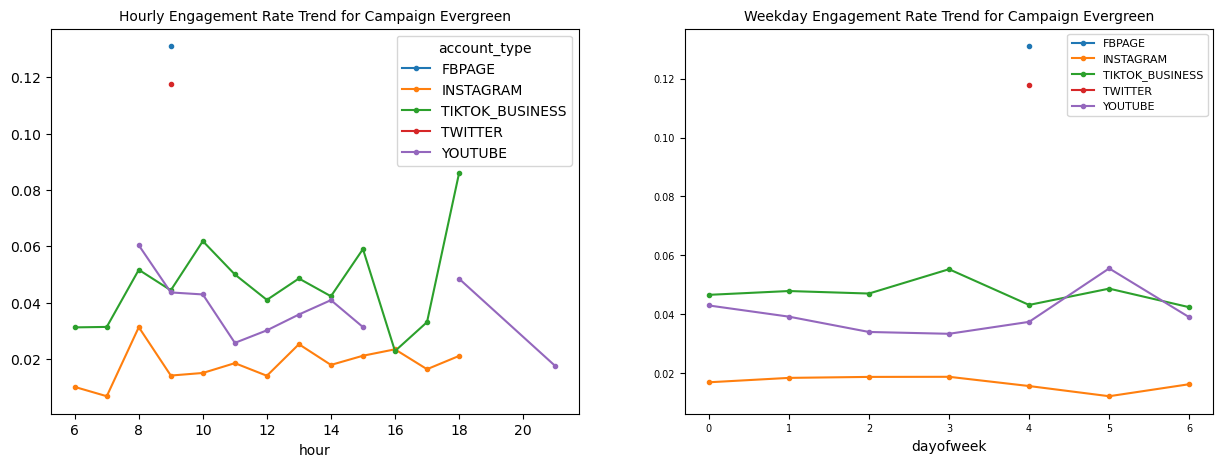

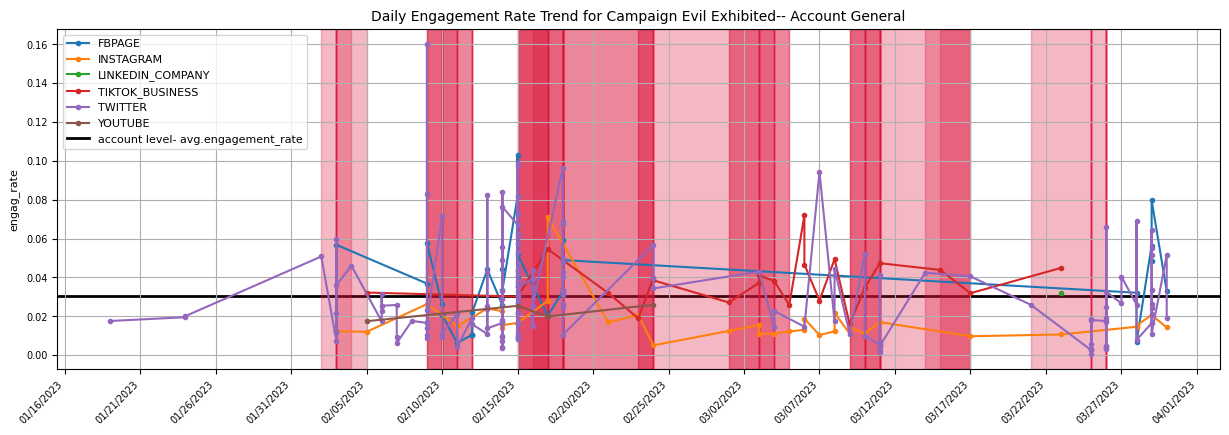

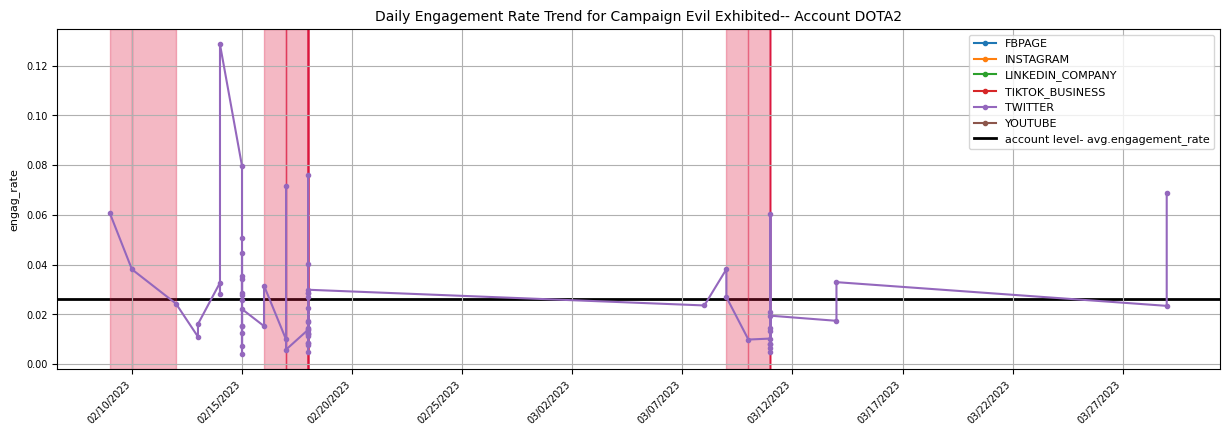

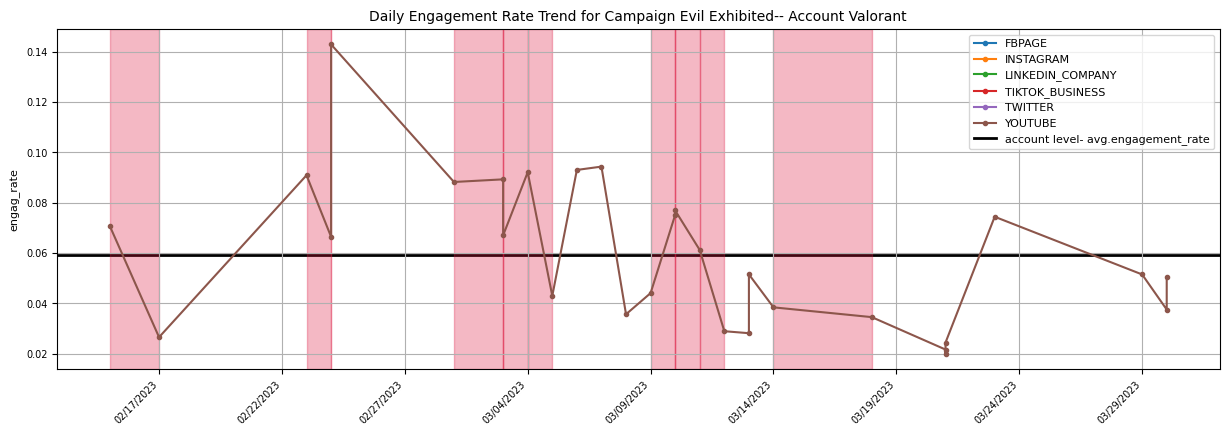

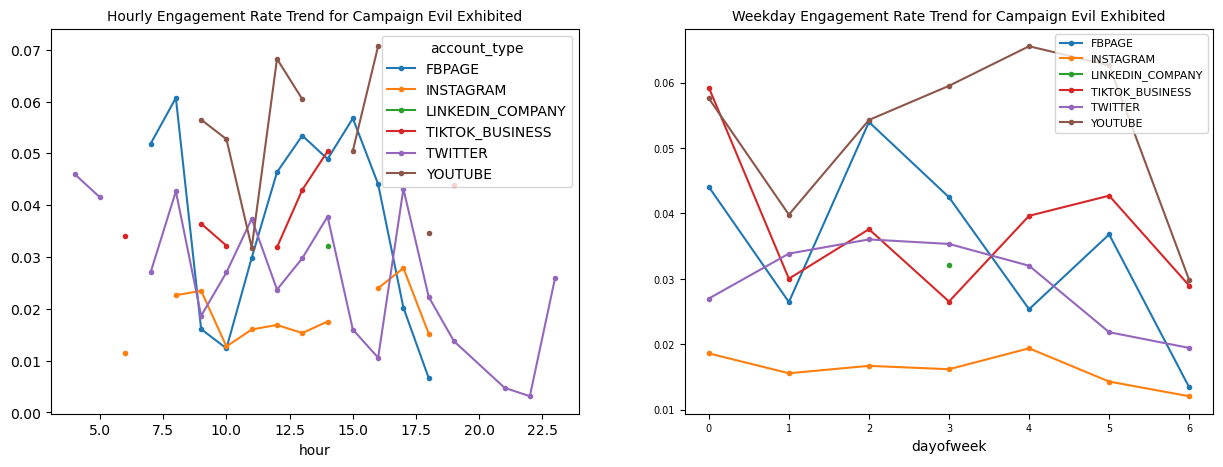

In [16]:
for campaign in ['Community Engagement','Evergreen', 'Evil Exhibited']:
    for account in social['account'].unique(): 
        df_campaign = social.loc[(social['campaign_name'] == campaign) & (social['account']== account)]
        if len(df_campaign)>2:
            plotTimeSeries(df_campaign,'date','account_type','engag_rate',title='Daily Engagement Rate Trend for Campaign '+str(campaign) +'-- Account '+str(account))

    #social.loc[(social['campaign_name'] == campaign)].groupby(['hour'])['engag_rate'].agg(['mean']).plot()
    fig, axes = plt.subplots(figsize=(15,5),ncols=2)
    bycampaign= pd.pivot_table(social.loc[(social['campaign_name'] == campaign)].reset_index(),index='hour', columns='account_type', values='engag_rate')
    bycampaign.plot(ax=axes[0],kind='line',marker='.')
    byweekday=pd.pivot_table(social.loc[(social['campaign_name'] == campaign)].reset_index(),index='dayofweek', columns='account_type', values='engag_rate')
    byweekday.plot(ax=axes[1],kind='line',marker='.') 
    plt.tick_params(axis='both',labelsize=7)
    axes[0].set_title('Hourly Engagement Rate Trend for Campaign '+str(campaign),fontsize=10)
    axes[1].set_title('Weekday Engagement Rate Trend for Campaign '+str(campaign),fontsize=10)
    plt.legend(fontsize= 8)
    

In [17]:
socialTN=social.drop(['published_date','hour','date'],axis=1)

In [18]:
lbl = preprocessing.LabelEncoder()
for i in ['monthstart','timeofday','weekend']:
          socialTN[i]= lbl.fit_transform(socialTN[i])

In [19]:
socialEncoded=pd.get_dummies(socialTN,drop_first=True)
xSocial= socialEncoded.drop('engag_rate',axis=1)
transformer=FunctionTransformer(np.log,inverse_func=np.exp)
logySocial=transformer.transform(social['engag_rate'])

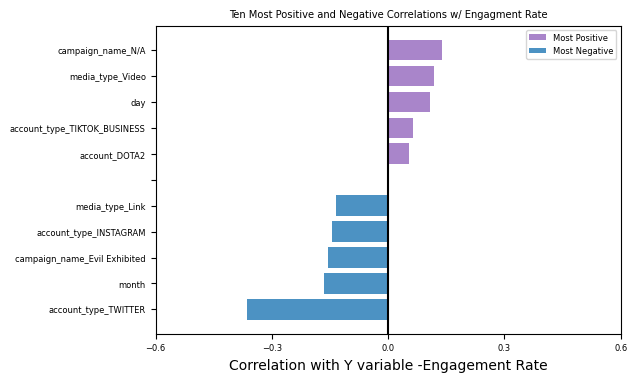

In [20]:
corr= xSocial.corrwith(logySocial)
#Top & Bottom 5 significant variables 
k=5
sortedCorr= corr.sort_values(ascending=False)
sigVar= pd.concat([xSocial[sortedCorr.head(5).index], 
           xSocial[sortedCorr.tail(5).index]],axis='columns')

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update({'font.size':6})
top_range = range(10, 5, -1)
bottom_range = range(4, -1, -1)

ax.barh(top_range, sortedCorr.head(5), color="tab:purple", 
        alpha=0.8, label="Most Positive")
ax.axvline(0, color="black")
ax.barh(bottom_range, sortedCorr.tail(5), color="tab:blue", 
        alpha=0.8, label="Most Negative")

ax.set_xticks(np.linspace(-.6, .6, 5))
ax.set_xlabel("Correlation with Y variable -Engagement Rate")

ax.set_yticks(range(10, -1, -1))
names = sortedCorr.head(5).index.tolist() + [""] + sortedCorr.tail(5).index.tolist()
ax.set_yticklabels(names)

ax.set_title("Ten Most Positive and Negative Correlations w/ Engagment Rate")
ax.legend()
plt.tick_params(axis='both',labelsize=6)
plt.show()

#### **V.EXPERIMENTAL MODEL DEVELOPMENTS**
> - XGBREGRESSOR, RANDOM FOREST, LOGISTIC REGRESSION

In [21]:
X_train, X_test, y_train, y_test = train_test_split(xSocial, logySocial, test_size=0.2, random_state=961)
print(X_train.shape,X_test.shape)
scaler= StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

(2008, 25) (502, 25)


In [22]:
from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import mlflow
import mlflow.xgboost

In [23]:

def train(params):
  curr_model =  XGBRegressor(learning_rate=params[0],
                            gamma=int(params[1]),
                            max_depth=int(params[2]),
                            n_estimators=int(params[3]),
                            min_child_weight = params[4], objective='reg:squarederror')
  score = -cross_val_score(curr_model, X_train, y_train, scoring='neg_mean_squared_error').mean()
  score = np.array(score)
  
  return {'loss': score, 'status': STATUS_OK, 'model': curr_model}
 
 
# define search parameters and whether discrete or continuous
search_space = [ hp.uniform('learning_rate', 0, 1),
                 hp.uniform('gamma', 0, 5),
                 hp.randint('max_depth', 10),
                 hp.randint('n_estimators', 20),
                 hp.randint('min_child_weight', 10)
               ]
# define the search algorithm (TPE or Randomized Search)
algo= tpe.suggest
 
 
from hyperopt import SparkTrials
search_parallelism = 4
spark_trials = SparkTrials(parallelism=search_parallelism)
 
with mlflow.start_run():
  argmin = fmin(
    fn=train,
    space=search_space,
    algo=algo,
    max_evals=8,
    trials=spark_trials)
  
mlflow.end_run()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/29 18:47:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

 50%|█████     | 4/8 [00:08<00:08,  2.01s/trial, best loss: 0.44824957271971255]

23/05/29 18:47:44 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


/Users/celine/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/celine/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/celine/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/celine/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/Users/celine/opt/an

 75%|███████▌  | 6/8 [00:11<00:03,  1.81s/trial, best loss: 0.44824957271971255]

 88%|████████▊ | 7/8 [00:12<00:01,  1.62s/trial, best loss: 0.44824957271971255]

100%|██████████| 8/8 [00:13<00:00,  1.64s/trial, best loss: 0.4474398946096187] 


Total Trials: 8: 8 succeeded, 0 failed, 0 cancelled.


In [24]:
def fit_best_model(X, y, argmin): 
  xgb_regressor =  XGBRegressor(objective='reg:squarederror', **argmin)
  xgb_model = xgb_regressor.fit(X, y, verbose=False)
  return(xgb_model)

xgb_model = fit_best_model(X_train, y_train, argmin) 
mlflow.xgboost.log_model(xgb_model, "xgboost") 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)
 
print('Train r2 score: ', r2_score(train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, test_pred))
train_mse = mean_squared_error(train_pred, y_train)
test_mse = mean_squared_error(test_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)
mlflow.end_run()

/Users/celine/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(
/Users/celine/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(
/Users/celine/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: min_child_weight is not saved in Scikit-Learn meta.
  warnings.warn(


Train r2 score:  0.26192622288468337
Test r2 score:  0.5887688584033857
Train RMSE: 0.6126
Test RMSE: 0.6949


/Users/celine/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


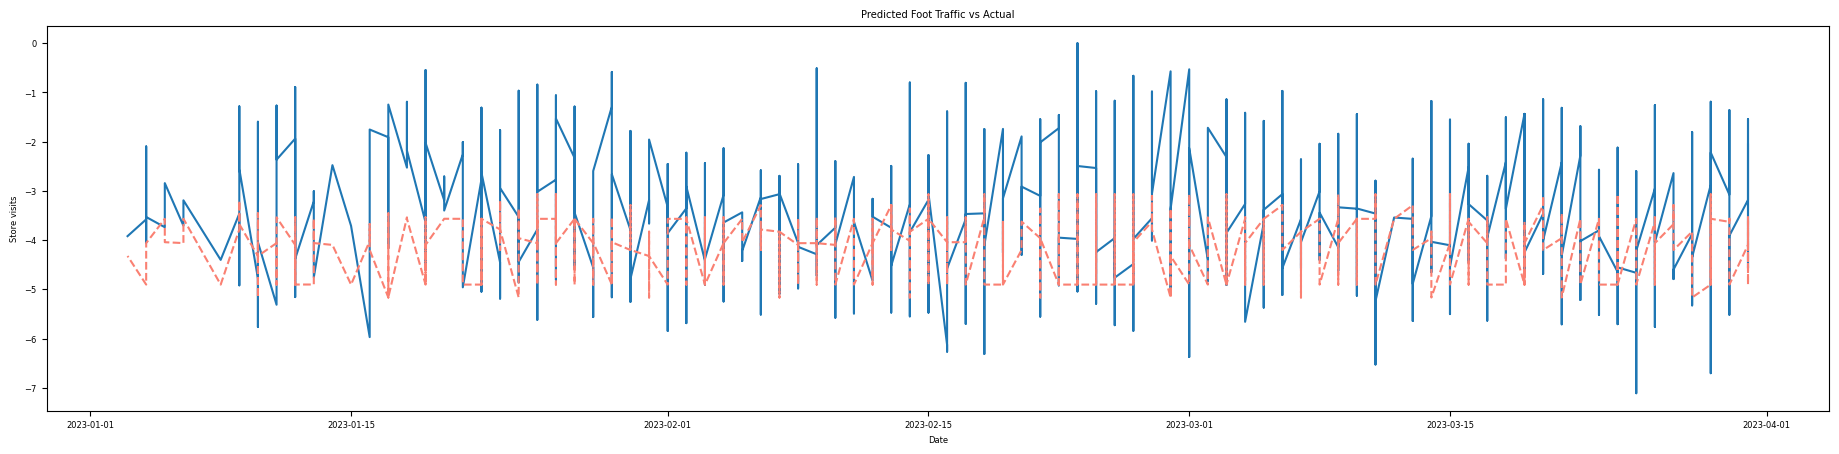

In [25]:

plt.figure(figsize=(23,5))
plt.plot(social['date'], logySocial)
plt.plot(social['date'], xgb_model.predict(xSocial), color='salmon', linestyle='--')
plt.title('Predicted Foot Traffic vs Actual')
plt.ylabel('Store visits')
plt.xlabel('Date')
plt.show()

In [26]:

from sklearn.model_selection import GridSearchCV

grid_search = {'max_depth': [2,3,4],
               'min_samples_leaf': [1,2,4],
               'min_samples_split': [2,4,6],
               'n_estimators': range(80,200,20)}

clf = RandomForestRegressor(random_state=961)
randomForest = GridSearchCV(estimator = clf, param_grid = grid_search,cv = 4, verbose= 1, n_jobs = -1)
randomForest.fit(X_train,y_train)
randomForest.best_estimator_

Fitting 4 folds for each of 162 candidates, totalling 648 fits


RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=160, random_state=961)

In [27]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse= np.sqrt(mean_squared_error(np.exp(test_labels),np.exp(predictions)))
    r2= r2_score(test_labels,predictions)
    print('Model Performance')
    print('RMSE Score: {:0.4f}.'.format(rmse))
    print('R-squared: {:0.4f}.'.format(r2))
    
    return rmse

rf_accuracy= evaluate(randomForest.best_estimator_,X_test,y_test)

Model Performance
RMSE Score: 0.0738.
R-squared: 0.5084.


In [28]:
par={
    'penalty' :['l1','l2','elasticnet'],
    'l1_ratio':np.linspace(.01,1.0,50),
    'alpha':np.linspace(.0001,10.0,50) 
}
sgdreg = SGDRegressor(random_state=961)
grid_search = GridSearchCV(estimator=sgdreg,param_grid=par,verbose=1,n_jobs=-1,
                           scoring="neg_root_mean_squared_error",cv=4)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best RMSE on TRAINING SET IS: %f using %s" % (abs(grid_result.best_score_), 
                             grid_result.best_params_))

Fitting 4 folds for each of 7500 candidates, totalling 30000 fits
Best RMSE on TRAINING SET IS: 0.752014 using {'alpha': 0.0001, 'l1_ratio': 0.01, 'penalty': 'l2'}


In [29]:
evaluate(grid_result.best_estimator_,X_test,y_test)

Model Performance
RMSE Score: 0.0729.
R-squared: 0.4833.


0.07293598705166224

#### TRY LOGISTIC 

In [30]:
yCat=pd.qcut(social['engag_rate'],q=4,labels=['poor(<.017)','average(<.034)','good(<.066)','great(>.066)'])
yCat.value_counts()

poor(<.017)       628
great(>.066)      628
average(<.034)    627
good(<.066)       627
Name: engag_rate, dtype: int64

In [31]:
xTrain, xTest, yTrain, yTest = train_test_split(xSocial, yCat, test_size=0.2, random_state=961)
print(xTrain.shape,xTest.shape)

(2008, 25) (502, 25)


In [32]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, mean_squared_error,accuracy_score,v_measure_score, silhouette_score,silhouette_samples
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [33]:
### Gradiant Descent/Logistic Regression as the Baseline Model 
sdg_params = { 
    'loss': ['log'], 
    'penalty': ['l2','elasticnet'],
    "l1_ratio" : np.arange(0,1,0.1),
    'alpha':np.linspace(0.1,2,10),
    'n_jobs': [-1]
    }
logModel= SGDClassifier(max_iter= 300,random_state=961)
grid= GridSearchCV(logModel, param_grid=sdg_params,cv=5)
grid.fit(xTrain,yTrain)
#model= LogisticRegression(solver='lbfgs',multi_class="multinomial").fit(xTrain,yTrain)

BModel= SGDClassifier(**grid.best_params_, max_iter= 3000,random_state=961)
BModel.fit(xTrain,yTrain)

f1Train= f1_score(yTrain,BModel.predict(xTrain),average='weighted')
f1Test= f1_score(yTest,BModel.predict(xTest),average='weighted') 
AccTest= accuracy_score(yTest,BModel.predict(xTest))

In [34]:
f1Test

0.42218142581095575